# Coursework Code for investigation of PRSH trader

This coursework entails the investigation of the Parametrised Response Stochastic Hill-Climber. 

In [29]:
pip install tabulate

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Initial Setup:
# Import all the libraries we need

import matplotlib.pyplot as plt
import numpy as np
import csv
import math
import random
import tabulate
from tabulate import tabulate
import pandas as pd
import statistics as stats
import seaborn as sns

from BSE import market_session

# The next are helper functions that you will use later, if they don't make 
# much sense now, don't worry too much about it they will become clearer later:

# Use this to plot trades of a single experiment
def plot_trades(trial_id):
    prices_fname = trial_id + '_transactions.csv'
    x = np.empty(0)
    y = np.empty(0)
    with open(prices_fname, newline='') as csvfile:
        reader = csv.reader(csvfile)
        for row in reader:
            time = float(row[1])
            price = float(row[2])
            x = np.append(x,time)
            y = np.append(y,price)

    plt.plot(x, y, 'x', color='black') 
    
# Use this to run an experiment n times and plot all trades
def n_runs_plot(n, trial_id, start_time, end_time, traders_spec, order_sched):
    x = np.empty(0)
    y = np.empty(0)

    for i in range(n):
        trialId = trial_id + '_' + str(i)
        tdump = open(trialId + '_avg_balance.csv','w')

        market_session(trialId, start_time, end_time, traders_spec, order_sched, tdump, True, False)
        
        tdump.close()

        with open(trialId + '_transactions.csv', newline='') as csvfile:
            reader = csv.reader(csvfile)
            for row in reader:
                time = float(row[1])
                price = float(row[2])
                x = np.append(x,time)
                y = np.append(y,price)

    plt.plot(x, y, 'x', color='black');

# !!! Don't use on it's own   
def getorderprice(i, sched, n, mode):
    pmin = min(sched[0][0], sched[0][1])
    pmax = max(sched[0][0], sched[0][1])
    prange = pmax - pmin
    stepsize = prange / (n - 1)
    halfstep = round(stepsize / 2.0)

    if mode == 'fixed':
        orderprice = pmin + int(i * stepsize)
    elif mode == 'jittered':
        orderprice = pmin + int(i * stepsize) + random.randint(-halfstep, halfstep)
    elif mode == 'random':
        if len(sched) > 1:
            # more than one schedule: choose one equiprobably
            s = random.randint(0, len(sched) - 1)
            pmin = min(sched[s][0], sched[s][1])
            pmax = max(sched[s][0], sched[s][1])
        orderprice = random.randint(pmin, pmax)
    return orderprice    

# !!! Don't use on it's own
def make_supply_demand_plot(bids, asks):
    # total volume up to current order
    volS = 0
    volB = 0

    fig, ax = plt.subplots()
    plt.ylabel('Price')
    plt.xlabel('Quantity')
    
    pr = 0
    for b in bids:
        if pr != 0:
            # vertical line
            ax.plot([volB,volB], [pr,b], 'r-')
        # horizontal lines
        line, = ax.plot([volB,volB+1], [b,b], 'r-')
        volB += 1
        pr = b
    if bids:
        line.set_label('Demand')
        
    pr = 0
    for s in asks:
        if pr != 0:
            # vertical line
            ax.plot([volS,volS], [pr,s], 'b-')
        # horizontal lines
        line, = ax.plot([volS,volS+1], [s,s], 'b-')
        volS += 1
        pr = s
    if asks:
        line.set_label('Supply')
        
    if bids or asks:
        plt.legend()
    plt.show()

# Use this to plot supply and demand curves from supply and demand ranges and stepmode
def sup_dem(seller_num, sup_ranges, buyer_num, dem_ranges, stepmode):
    asks = []
    for s in range(seller_num):
        asks.append(getorderprice(s, sup_ranges, seller_num, stepmode))
    asks.sort()
    bids = []
    for b in range(buyer_num):
        bids.append(getorderprice(b, dem_ranges, buyer_num, stepmode))
    bids.sort()
    bids.reverse()
    
    make_supply_demand_plot(bids, asks) 

# plot sorted trades, useful is some situations - won't be used in this worksheet
def in_order_plot(trial_id):
    prices_fname = trial_id + '_transactions.csv'
    y = np.empty(0)
    with open(prices_fname, newline='') as csvfile:
        reader = csv.reader(csvfile)
        for row in reader:
            price = float(row[2])
            y = np.append(y,price)
    y = np.sort(y)
    x = list(range(len(y)))

    plt.plot(x, y, 'x', color='black') 

def plot_time_series(trial_id):
    prices_fname = trial_id + '_avg_balance.csv'
    x = np.empty(0)
    y = np.empty(0)
    with open(prices_fname, newline='') as csvfile:
        reader = csv.reader(csvfile)
        for row in reader:
            time = float(row[1])
            price = float(row[7])
            x = np.append(x,time)
            y = np.append(y,price)
    

In [3]:
from BSE import Trader
class Trader_PRZI_SHC_IMPROVEMENT(Trader):


    # how to mutate the strategy values when hill-climbing
    def mutate_strat(self, s):
        sdev = 0.05
        newstrat = s
        while newstrat == s:
            newstrat = s + random.gauss(0.0, sdev)
            newstrat = max(-1.0, min(1.0, newstrat))
        return newstrat


    def strat_str(self):
        # pretty-print a string summarising this trader's strategies
        string = 'PRSH2: %s active_strat=[%d]:\n' % (self.tid, self.active_strat)
        for s in range(0, self.k):
            strat = self.strats[s]
            stratstr = '[%d]: s=%f, start=%f, $=%f, pps=%f\n' % \
                       (s, strat['stratval'], strat['start_t'], strat['profit'], strat['pps'])
            string = string + stratstr

        return string


    def __init__(self, ttype, tid, balance, time):
        # PRZI strategy defined by parameter "strat"
        # here this is randomly assigned
        # strat * direction = -1 = > GVWY; =0 = > ZIC; =+1 = > SHVR

        verbose = False

        Trader.__init__(self, ttype, tid, balance, time)
        self.theta0 = 100           # threshold-function limit value
        self.m = 4                  # tangent-function multiplier
        self.k = 4                  # number of hill-climbing points (cf number of arms on a multi-armed-bandit)
        self.strat_wait_time = 900  # how many secs do we give any one strat before switching? todo: make this randomized withn some range
        self.strat_range_min = 0.75 # lower-bound on randomly-assigned strategy-value
        self.strat_range_max = 0.75 # upper-bound on randomly-assigned strategy-value
        self.active_strat = 0       # which of the k strategies are we currently playing? -- start with 0
        self.prev_qid = None        # previous order i.d.
        self.strat_eval_time = self.k * self.strat_wait_time   # time to cycle through evaluating all k strategies
        self.last_strat_change_time = time  # what time did we last change strategies?
        self.profit_epsilon = 0.01 * random.random()    # minimum profit-per-sec difference between strategies that counts
        self.strats=[]              # strategies awaiting initialization
        self.pmax = None            # this trader's estimate of the maximum price the market will bear
        self.pmax_c_i = math.sqrt(random.randint(1,10))  # multiplier coefficient when estimating p_max

        for s in range(0, self.k):
            # initialise each of the strategies in sequence
            start_time = time
            profit = 0.0
            profit_per_second = 0
            lut_bid = None
            lut_ask = None
            if s == 0:
                strategy = random.uniform(self.strat_range_min, self.strat_range_max)
            else:
                strategy = self.mutate_strat(self.strats[0]['stratval'])     # mutant of strats[0]
            self.strats.append({'stratval': strategy, 'start_t': start_time,
                                'profit': profit, 'pps': profit_per_second, 'lut_bid': lut_bid, 'lut_ask': lut_ask})

        if verbose:
            print("PRSH2 %s %s\n" % (tid, self.strat_str()))


    def getorder(self, time, countdown, lob):

        # shvr_price tells us what price a SHVR would quote in these circs
        def shvr_price(otype, limit, lob):

            if otype == 'Bid':
                if lob['bids']['n'] > 0:
                    shvr_p = lob['bids']['best'] + 1   # BSE tick size is always 1
                    if shvr_p > limit:
                        shvr_p = limit
                else:
                    shvr_p = lob['bids']['worst']
            else:
                if lob['asks']['n'] > 0:
                    shvr_p = lob['asks']['best'] - 1   # BSE tick size is always 1
                    if shvr_p < limit:
                        shvr_p = limit
                else:
                    shvr_p = lob['asks']['worst']

            return shvr_p

        # calculate cumulative distribution function (CDF) look-up table (LUT)
        def calc_cdf_lut(strat, t0, m, dirn, pmin, pmax):
            # set parameter values and calculate CDF LUT
            # dirn is direction: -1 for buy, +1 for sell

            # the threshold function used to clip
            def threshold(theta0, x):
                t = max(-1*theta0, min(theta0, x))
                return t

            epsilon = 0.000001 #used to catch DIV0 errors
            verbose = False

            if (strat > 1.0) or (strat < -1.0):
                # out of range
                sys.exit('PRSH2 FAIL: PRZI.getorder() self.strat out of range\n')

            if (dirn != 1.0) and (dirn != -1.0):
                # out of range
                sys.exit('PRSH2 FAIL: PRZI.calc_cdf() bad dirn\n')

            if pmax < pmin:
                # screwed
                sys.exit('PRSH2 FAIL: pmax < pmin\n')

            dxs = dirn * strat

            if verbose:
                print('PRSH2 calc_cdf_lut: dirn=%d dxs=%d pmin=%d pmax=%d\n' % (dirn, dxs, pmin, pmax))

            p_range = float(pmax - pmin)
            if p_range < 1:
                # special case: the SHVR-style strategy has shaved all the way to the limit price
                # the lower and upper bounds on the interval are adjacent prices;
                # so cdf is simply the lower price with probability 1

                cdf=[{'price':pmin, 'cum_prob': 1.0}]

                if verbose:
                    print('\n\ncdf:', cdf)

                return {'strat': strat, 'dirn': dirn, 'pmin': pmin, 'pmax': pmax, 'cdf_lut': cdf}

            c = threshold(t0, m * math.tan(math.pi * (strat + 0.5)))

            # catch div0 errors here
            if abs(c) < epsilon:
                if c > 0:
                    c = epsilon
                else:
                    c = -epsilon

            e2cm1 = math.exp(c) - 1

            # calculate the discrete calligraphic-P function over interval [pmin, pmax]
            # (i.e., this is Equation 8 in the PRZI Technical Note)
            calp_interval = []
            calp_sum = 0
            for p in range(pmin, pmax + 1):
                p_r = (p - pmin) / (p_range)  # p_r in [0.0, 1.0]
                if strat == 0.0:
                    # special case: this is just ZIC
                    cal_p = 1 / (p_range + 1)
                elif strat > 0:
                    cal_p = (math.exp(c * p_r) - 1.0) / e2cm1
                else:  # self.strat < 0
                    cal_p = 1.0 - ((math.exp(c * p_r) - 1.0) / e2cm1)
                if cal_p < 0:
                    cal_p = 0   # just in case
                calp_interval.append({'price':p, "cal_p":cal_p})
                calp_sum += cal_p

            if calp_sum <= 0:
                print('calp_interval:', calp_interval)
                print('pmin=%f, pmax=%f, calp_sum=%f' % (pmin, pmax, calp_sum))

            cdf = []
            cum_prob = 0
            # now go thru interval summing and normalizing to give the CDF
            for p in range(pmin, pmax + 1):
                price = calp_interval[p-pmin]['price'] # todo: what does this do?
                cal_p = calp_interval[p-pmin]['cal_p']
                prob = cal_p / calp_sum
                cum_prob += prob
                cdf.append({'price': p, 'cum_prob': cum_prob}) #todo shouldnt ths be "price" not "p"?

            if verbose:
                print('\n\ncdf:', cdf)

            return {'strat':strat, 'dirn':dirn, 'pmin':pmin, 'pmax':pmax, 'cdf_lut':cdf}

        verbose = False

        if verbose:
            print('t=%f PRSH2 getorder: %s, %s' % (time, self.tid, self.strat_str()))

        if len(self.orders) < 1:
            # no orders: return NULL
            order = None
        else:
            # unpack the assignment-order
            limit = self.orders[0].price
            otype = self.orders[0].otype
            qid = self.orders[0].qid

            if self.prev_qid is None:
                self.prev_qid = qid

            if qid != self.prev_qid:
                # customer-order i.d. has changed, so we're working a new customer-order now
                # this is the time to switch arms
                # print("New order! (how does it feel?)")
                dummy = 1

            # get extreme limits on price interval
            # lowest price the market will bear
            minprice = int(lob['bids']['worst'])  # default assumption: worst bid price possible is 1 tick
            # trader's individual estimate highest price the market will bear
            maxprice = self.pmax # default assumption
            if self.pmax is None:
                maxprice = int(limit * self.pmax_c_i + 0.5) # in the absence of any other info, guess
                self.pmax = maxprice
            elif lob['asks']['sess_hi'] is not None:
                if self.pmax < lob['asks']['sess_hi']:        # some other trader has quoted higher than I expected
                    maxprice = lob['asks']['sess_hi']         # so use that as my new estimate of highest
                    self.pmax = maxprice

            # what price would a SHVR quote?
            p_shvr = shvr_price(otype, limit, lob)

            # it may be more efficient to detect the ZIC special case and generate a price directly
            # whether it is or not depends on how many entries need to be sampled in the LUT reverse-lookup
            # versus the compute time of the call to random.randint that would be used in direct ZIC
            # here, for simplicity, we're not treating ZIC as a special case...
            # ... so the full CDF LUT needs to be instantiated for ZIC (strat=0.0) just like any other strat value

            # use the cdf look-up table
            # cdf_lut is a list of little dictionaries
            # each dictionary has form: {'cum_prob':nnn, 'price':nnn}
            # generate u=U(0,1) uniform disrtibution
            # starting with the lowest nonzero cdf value at cdf_lut[0],
            # walk up the lut (i.e., examine higher cumulative probabilities),
            # until we're in the range of u; then return the relevant price

            strat = self.strats[self.active_strat]['stratval']

            if otype == 'Bid':

                # direction * strat
                dxs = -1 * strat  # the minus one multiplier is the "buy" direction

                p_max = int(limit)
                if dxs <= 0:
                    p_min = minprice        # this is delta_p for BSE, i.e. ticksize =1
                else:
                    # shade the lower bound on the interval
                    # away from minprice and toward shvr_price
                    p_min = int(0.5 + (dxs * p_shvr) + ((1.0-dxs) * minprice))

                lut_bid = self.strats[self.active_strat]['lut_bid']
                if (lut_bid is None) or \
                        (lut_bid['strat'] != strat) or\
                        (lut_bid['pmin'] != p_min) or \
                        (lut_bid['pmax'] != p_max):
                    # need to compute a new LUT
                    if verbose:
                        print('New bid LUT')
                    self.strats[self.active_strat]['lut_bid'] = calc_cdf_lut(strat, self.theta0, self.m, -1, p_min, p_max)

                lut = self.strats[self.active_strat]['lut_bid']

            else:   # otype == 'Ask'

                dxs = strat

                p_min = int(limit)
                if dxs <= 0:
                    p_max = maxprice
                else:
                    # shade the upper bound on the interval
                    # away from maxprice and toward shvr_price
                    p_max = int(0.5 + (dxs * p_shvr) + ((1.0-dxs) * maxprice))

                lut_ask = self.strats[self.active_strat]['lut_ask']
                if (lut_ask is None) or \
                        (lut_ask['strat'] != strat) or \
                        (lut_ask['pmin'] != p_min) or \
                        (lut_ask['pmax'] != p_max):
                    # need to compute a new LUT
                    if verbose:
                        print('New ask LUT')
                    self.strats[self.active_strat]['lut_ask'] = calc_cdf_lut(strat, self.theta0, self.m, +1, p_min, p_max)

                lut = self.strats[self.active_strat]['lut_ask']

            if verbose:
                # print('PRZI LUT =', lut)
                # print ('[LUT print suppressed]')
                dummy = 1

            # do inverse lookup on the LUT to find the price
            u = random.random()
            for entry in lut['cdf_lut']:
                if u < entry['cum_prob']:
                    quoteprice = entry['price']
                    break

            order = Order(self.tid, otype, quoteprice, self.orders[0].qty, time, lob['QID'])

            self.lastquote = order

        return order


    def bookkeep(self, trade, order, verbose, time):

        outstr = ""
        for order in self.orders:
            outstr = outstr + str(order)

        self.blotter.append(trade)  # add trade record to trader's blotter
        # NB What follows is **LAZY** -- assumes all orders are quantity=1
        transactionprice = trade['price']
        if self.orders[0].otype == 'Bid':
            profit = self.orders[0].price - transactionprice
        else:
            profit = transactionprice - self.orders[0].price
        self.balance += profit
        self.n_trades += 1
        self.profitpertime = self.balance / (time - self.birthtime)

        if profit < 0:
            print(profit)
            print(trade)
            print(order)
            sys.exit('PRSH2 FAIL: negative profit')

        if verbose: print('%s profit=%d balance=%d profit/time=%d' % (outstr, profit, self.balance, self.profitpertime))
        self.del_order(order)  # delete the order

        # Trader.bookkeep(self, trade, order, verbose, time) -- todo: calls all of the above?

        # todo: expand from here

        # Check: bookkeep is only called after a successful trade? i.e. no need to check re trade or not

        # so ...
        # if I have just traded and I am a PRSH trader
        # then I want to reset the timer on the current strat and update its profit sum

        self.strats[self.active_strat]['profit'] += profit


    # PRSH respond() asks/answers two questions
    # do we need to choose a new strategy? (i.e. have just completed/cancelled previous customer order)
    # do we need to dump one arm and generate a new one? (i.e., both/all arms have been evaluated enough)
    def respond(self, time, lob, trade, verbose):

        shc_algo = 'basic'

        # "basic" is a very basic form of stochastic hill-cliber (SHC) that v easy to understand and to code
        # it cycles through the k different strats until each has been operated for at least eval_time seconds
        # but a strat that does nothing will get swapped out if it's been running for no_deal_time without a deal
        # then the strats with the higher total accumulated profit is retained,
        # and mutated versions of it are copied into the other strats
        # then all counters are reset, and this is repeated indefinitely
        # todo: add in other shc_algo that are cleverer than this,
        # e.g. inspired by multi-arm-bandit algos like like epsilon-greedy, softmax, or upper confidence bound (UCB)

        verbose = False

        # first update each strategy's profit-per-second value -- this is the "fitness" of each strategy
        for s in self.strats:
            pps_time = time - s['start_t']
            if pps_time > 0:
                s['pps'] = s['profit'] / pps_time
            else:
                s['pps'] = 0.0


        if shc_algo == 'basic':

            if verbose:
                # print('t=%f %s PRSH respond: shc_algo=%s eval_t=%f max_wait_t=%f' %
                #     (time, self.tid, shc_algo, self.strat_eval_time, self.strat_wait_time))
                dummy = 1

            # do we need to swap strategies?
            # this is based on time elapsed since last reset -- waiting for the current strategy to get a deal
            # -- otherwise a hopeless strategy can just sit there for ages doing nothing,
            # which would disadvantage the *other* strategies because they would never get a chance to score any profit.
            # when a trader does a deal, clock is reset; todo check this!!!
            # clock also reset when new a strat is created, obvs. todo check this!!! also check bookkeeping/proft etc

            # NB this *cycles* through the available strats in sequence

            s = self.active_strat
            time_elapsed = time - self.last_strat_change_time
            if time_elapsed > self.strat_wait_time:
                # we have waited long enough: swap to another strategy

                new_strat = s + 1
                if new_strat > self.k - 1:
                    new_strat = 0

                self.active_strat = new_strat
                self.last_strat_change_time = time

                if verbose:
                    print('t=%f %s PRSH2 respond: strat[%d] elapsed=%f; wait_t=%f, switched to strat=%d' %
                          (time, self.tid, s, time_elapsed, self.strat_wait_time, new_strat))

            # code below here deals with creating a new set of k-1 mutants from the best of the k strats

            for s in self.strats:
                # assume that all strats have had long enough, and search for evidence to the contrary
                all_old_enough = True
                lifetime = time - s['start_t']
                if lifetime < self.strat_eval_time:
                    all_old_enough = False
                    break

            if all_old_enough:
                # all strategies have had long enough: which has made most profit?

                # sort them by profit
                strats_sorted = sorted(self.strats, key = lambda k: k['pps'], reverse = True)
                # strats_sorted = self.strats     # use this as a control: unsorts the strats, gives pure random walk.

                if verbose:
                    print('PRSH2 %s: strat_eval_time=%f, all_old_enough=True' % (self.tid, self.strat_eval_time))
                    for s in strats_sorted:
                        print('s=%f, start_t=%f, lifetime=%f, $=%f, pps=%f' %
                              (s['stratval'], s['start_t'], time-s['start_t'], s['profit'], s['pps']))

                # if the difference between the top two strats is too close to call then flip a coin
                # this is to prevent the same good strat being held constant simply by chance cos it is at index [0]
                prof_diff = strats_sorted[0]['profit'] - strats_sorted[1]['profit']
                if abs(prof_diff) < self.profit_epsilon:
                    # they're too close to call, so just flip a coin
                    best_strat = random.randint(0,1)
                elif prof_diff > 0:
                    best_strat = 0
                else:
                    best_strat = 1

                if best_strat == 1:
                    # need to swap strats[0] and strats[1]
                    tmp_strat = strats_sorted[0]
                    strats_sorted[0] = strats_sorted[1]
                    strats_sorted[1] = tmp_strat

                # the sorted list of strats replaces the existing list
                self.strats = strats_sorted

                # at this stage, strats_sorted[0] is our newly-chosen elite-strat, about to replicate
                # record it
                

                # now replicate and mutate elite into all the other strats
                for s in range(1, self.k):    # note range index starts at one not zero
                    self.strats[s]['stratval'] = self.mutate_strat(self.strats[0]['stratval'])
                    self.strats[s]['start_t'] = time
                    self.strats[s]['profit'] = 0.0
                    self.strats[s]['pps'] = 0.0
                # and then update (wipe) records for the elite
                self.strats[0]['start_t'] = time
                self.strats[0]['profit'] = 0.0
                self.strats[0]['pps'] = 0.0

                if verbose:
                    print('%s: strat_eval_time=%f, MUTATED:' % (self.tid, self.strat_eval_time))
                    for s in self.strats:
                        print('s=%f start_t=%f, lifetime=%f, $=%f, pps=%f' %
                              (s['stratval'], s['start_t'], time-s['start_t'], s['profit'], s['pps']))

        else:
            sys.exit('FAIL: bad value for shc_algo')

### Supply and Demand Curves

#### Supply and Demand Ranges 

In [4]:
sup_range = (1,500)
dem_range = sup_range

In [5]:
start_time = 0
end_time = 60 * 10
supply_schedule = [{'from': start_time, 'to': end_time, 'ranges': [sup_range], 'stepmode': 'fixed'}]
demand_schedule = [{'from': start_time, 'to': end_time, 'ranges': [dem_range], 'stepmode': 'fixed'}]

You can use the provided "sup_dem" function that we defined earlier (at the top of this worksheet) to print the supply and demand curves of experiments.

Run the code below:

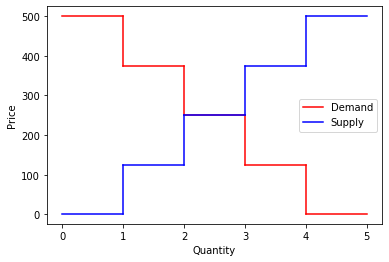

In [6]:
sup_dem(5, [sup_range], 5, [dem_range], 'fixed')

You should now see demand and supply that you have configured for the market plotted above.

### Homogeneous Experiments

In this section we will conduct the homogeneous experiments for our 4 trader-agent strategies that we will be testing.

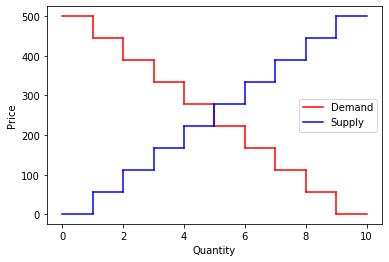

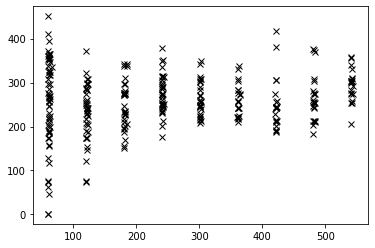

In [7]:
sellers_spec = [('ZIP',10)]
buyers_spec = sellers_spec
traders_spec = {'sellers':sellers_spec,'buyers':buyers_spec}

sup_range = (1,500)
dem_range = sup_range

start_time = 0
end_time = 60 * 10
supply_schedule = [{'from': start_time, 'to': end_time, 'ranges': [sup_range], 'stepmode': 'fixed'}]
demand_schedule = [{'from': start_time, 'to': end_time, 'ranges': [dem_range], 'stepmode': 'fixed'}]

sup_dem(10, [sup_range], 10, [dem_range], 'fixed')

order_interval = 60
order_sched = {'sup': supply_schedule, 'dem': demand_schedule,
               'interval': order_interval, 'timemode': 'periodic'}

trial_id = 'test_ZIP'
tdump = open('test_ZIP_avg_balance.csv','w')
dump_all = True
verbose = False

market_session(trial_id, start_time, end_time, traders_spec, order_sched, tdump, dump_all, verbose)

tdump.close()

plot_trades('test_ZIP')

n_runs_plot(10, trial_id, start_time, end_time, traders_spec, order_sched)

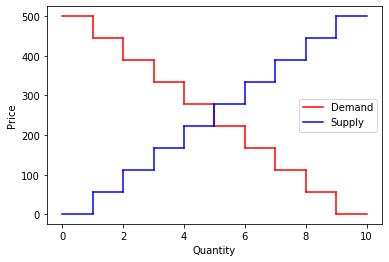

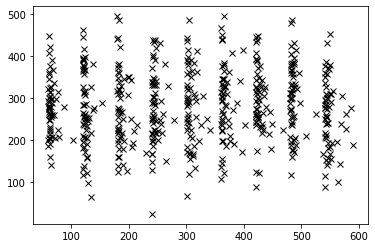

In [8]:
sellers_spec = [('ZIC',10)]
buyers_spec = sellers_spec
traders_spec = {'sellers':sellers_spec,'buyers':buyers_spec}

sup_range = (1,500)
dem_range = sup_range

start_time = 0
end_time = 60 * 10
supply_schedule = [{'from': start_time, 'to': end_time, 'ranges': [sup_range], 'stepmode': 'fixed'}]
demand_schedule = [{'from': start_time, 'to': end_time, 'ranges': [dem_range], 'stepmode': 'fixed'}]

sup_dem(10, [sup_range], 10, [dem_range], 'fixed')

order_interval = 60
order_sched = {'sup': supply_schedule, 'dem': demand_schedule,
               'interval': order_interval, 'timemode': 'periodic'}

trial_id = 'test_ZIC'
tdump = open('test_ZIC_avg_balance.csv','w')
dump_all = True
verbose = False

market_session(trial_id, start_time, end_time, traders_spec, order_sched, tdump, dump_all, verbose)

tdump.close()

plot_trades('test_ZIC')

n_runs_plot(10, trial_id, start_time, end_time, traders_spec, order_sched)

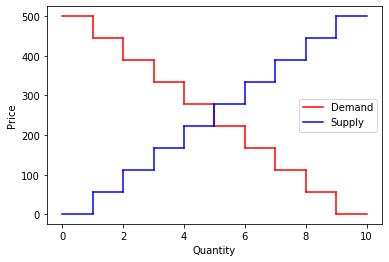

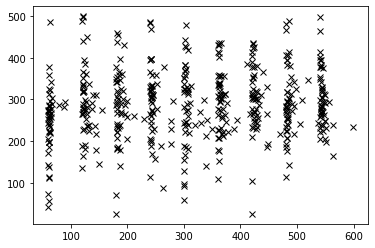

In [9]:
sellers_spec = [('PRZI',10)]
buyers_spec = sellers_spec
traders_spec = {'sellers':sellers_spec,'buyers':buyers_spec}

sup_range = (1,500)
dem_range = sup_range

start_time = 0
end_time = 60 * 10
supply_schedule = [{'from': start_time, 'to': end_time, 'ranges': [sup_range], 'stepmode': 'fixed'}]
demand_schedule = [{'from': start_time, 'to': end_time, 'ranges': [dem_range], 'stepmode': 'fixed'}]

sup_dem(10, [sup_range], 10, [dem_range], 'fixed')

order_interval = 60
order_sched = {'sup': supply_schedule, 'dem': demand_schedule,
               'interval': order_interval, 'timemode': 'periodic'}

trial_id = 'test_PRZI'
tdump = open('test_PRZI_avg_balance.csv','w')
dump_all = True
verbose = False

market_session(trial_id, start_time, end_time, traders_spec, order_sched, tdump, dump_all, verbose)

tdump.close()

plot_trades('test_PRZI')

n_runs_plot(10, trial_id, start_time, end_time, traders_spec, order_sched)

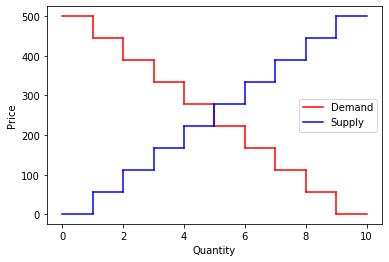

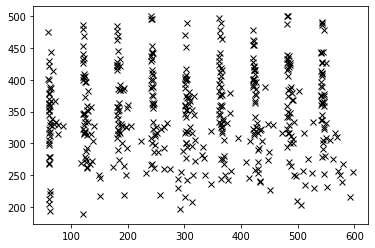

In [10]:
sellers_spec = [('PRSH',10)]
buyers_spec = sellers_spec
traders_spec = {'sellers':sellers_spec,'buyers':buyers_spec}

sup_range = (1,500)
dem_range = sup_range

start_time = 0
end_time = 60 * 10
supply_schedule = [{'from': start_time, 'to': end_time, 'ranges': [sup_range], 'stepmode': 'fixed'}]
demand_schedule = [{'from': start_time, 'to': end_time, 'ranges': [dem_range], 'stepmode': 'fixed'}]

sup_dem(10, [sup_range], 10, [dem_range], 'fixed')

order_interval = 60
order_sched = {'sup': supply_schedule, 'dem': demand_schedule,
               'interval': order_interval, 'timemode': 'periodic'}

trial_id = 'test_PRSH'
tdump = open('test_PRSH_avg_balance.csv','w')
dump_all = True
verbose = False

market_session(trial_id, start_time, end_time, traders_spec, order_sched, tdump, dump_all, verbose)

tdump.close()

plot_trades('test_PRSH')

n_runs_plot(10, trial_id, start_time, end_time, traders_spec, order_sched)

In [4]:
# in this cell we will be plotting the table that will be included in my paper
df = pd.read_csv('test_ZIP_transactions.csv')
x_ZIP=df.iloc[:,2]#values of the transaction, I want the average

df_1 = pd.read_csv('test_ZIC_transactions.csv')
x_ZIC = df_1.iloc[:,2]#values of the transaction, I want the average

df_2 = pd.read_csv('test_PRZI_transactions.csv')
x_PRZI = df_2.iloc[:,2]#values of the transaction, I want the average

df_3 = pd.read_csv('test_PRSH_transactions.csv')
x_PRSH = df_3.iloc[:,2]#values of the transaction, I want the average

In [5]:
df = pd.read_csv('test_ZIP_avg_balance.csv')
x_1 = stats.mean(df[df.columns[7]])
df_zic = pd.read_csv('test_ZIC_avg_balance.csv')
x_2 = stats.mean(df_zic[df_zic.columns[7]])
df_przi = pd.read_csv('test_PRZI_avg_balance.csv')
x_3 = stats.mean(df_przi[df_przi.columns[7]])
df_prsh = pd.read_csv('test_PRSH_avg_balance.csv')
x_4 = stats.mean(df_prsh[df_prsh.columns[7]])

In [6]:
fd = pd.read_csv('test_ZIP_transactions.csv')
t_1 = max(fd[fd.columns[2]])
fd_1 = pd.read_csv('test_ZIC_transactions.csv')
t_2 = max(fd_1[fd_1.columns[2]])
fd_3 = pd.read_csv('test_PRZI_transactions.csv')
t_3 = max(fd_3[fd_3.columns[2]])
fd_4 = pd.read_csv('test_PRSH_transactions.csv')
t_4 = max(fd_4[fd_4.columns[2]])

In [7]:

ts = plot_time_series('test_ZIP')
tt = plot_time_series('test_ZIC')
tu = plot_time_series('test_PRZI')
tv = plot_time_series('test_PRSH')

In [16]:
homogeneous_info = {'Trading Agent':['PRSH','PRZI','ZIC','ZIP'],'Mean Transaction Value':
                    [stats.mean(x_PRSH),stats.mean(x_PRZI),stats.mean(x_ZIC),stats.mean(x_ZIP)],
                    'Average profit per trading agent':[x_4,x_3,x_2,x_1],'Total Profit':[11039,10759,11704,5438],
                    'Highest Trade Price':[t_4,t_3,t_2,t_1]}

table_hom = tabulate(homogeneous_info,headers='keys',tablefmt='pretty')
print(table_hom)


+---------------+------------------------+----------------------------------+--------------+---------------------+
| Trading Agent | Mean Transaction Value | Average profit per trading agent | Total Profit | Highest Trade Price |
+---------------+------------------------+----------------------------------+--------------+---------------------+
|     PRSH      |   354.9756097560976    |              302.2               |    11039     |         496         |
|     PRZI      |        315.375         |              282.3               |    10759     |         489         |
|      ZIC      |         269.08         |        308.1764705882353         |    11704     |         449         |
|      ZIP      |   289.1764705882353    |        144.09444444444443        |     5438     |         397         |
+---------------+------------------------+----------------------------------+--------------+---------------------+


In [17]:
#we use the values in the columns of the transaction.csv files for the two bots with the highest total profit. 
import scipy
import scipy.stats
df = pd.read_csv('test_PRSH_transactions.csv')
dff = pd.read_csv('test_ZIC_transactions.csv')
x = df[df.columns[2]]
y = dff[dff.columns[2]]
scipy.stats.mannwhitneyu(x,y)

MannwhitneyuResult(statistic=434.0, pvalue=1.2357540406906842e-06)

## Heterogeneous experiments

###  Balanced-group 

This experiment is where we fight each bot against the PRSH bot, since it is the bot that we are interested in. The design of this experiment is so that there are 5 of the PRSH agent and 5 of any of the others. 

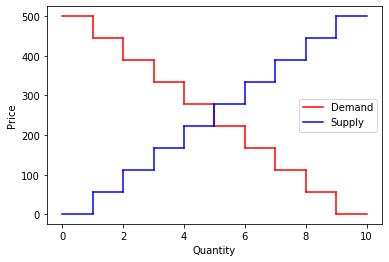

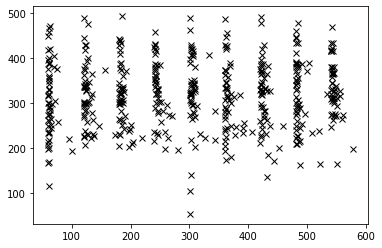

In [23]:
sellers_spec = [('PRSH',5),('PRZI',5)]
buyers_spec = sellers_spec
traders_spec = {'sellers':sellers_spec,'buyers':buyers_spec}

sup_range = (1,500)
dem_range = sup_range

start_time = 0
end_time = 60 * 10
supply_schedule = [{'from': start_time, 'to': end_time, 'ranges': [sup_range], 'stepmode': 'fixed'}]
demand_schedule = [{'from': start_time, 'to': end_time, 'ranges': [dem_range], 'stepmode': 'fixed'}]

sup_dem(10, [sup_range], 10, [dem_range], 'fixed')

order_interval = 60
order_sched = {'sup': supply_schedule, 'dem': demand_schedule,
               'interval': order_interval, 'timemode': 'periodic'}

trial_id = 'test1_PRSH_PRZI'
tdump = open('test1_PRSH_PRZI_avg_balance.csv','w')
dump_all = True
verbose = False

market_session(trial_id, start_time, end_time, traders_spec, order_sched, tdump, dump_all, verbose)

tdump.close()

plot_trades('test1_PRSH_PRZI')

n_runs_plot(10, trial_id, start_time, end_time, traders_spec, order_sched)

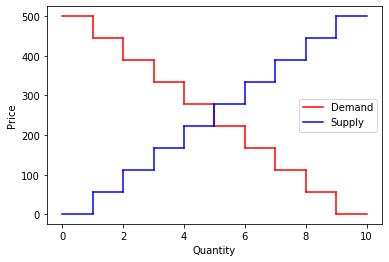

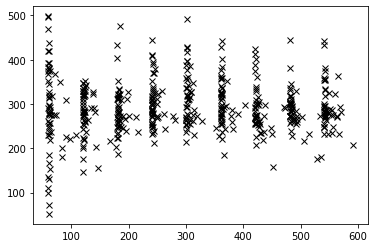

In [24]:
sellers_spec = [('PRSH',5),('ZIP',5)]
buyers_spec = sellers_spec
traders_spec = {'sellers':sellers_spec,'buyers':buyers_spec}

sup_range = (1,500)
dem_range = sup_range

start_time = 0
end_time = 60 * 10
supply_schedule = [{'from': start_time, 'to': end_time, 'ranges': [sup_range], 'stepmode': 'fixed'}]
demand_schedule = [{'from': start_time, 'to': end_time, 'ranges': [dem_range], 'stepmode': 'fixed'}]

sup_dem(10, [sup_range], 10, [dem_range], 'fixed')

order_interval = 60
order_sched = {'sup': supply_schedule, 'dem': demand_schedule,
               'interval': order_interval, 'timemode': 'periodic'}

trial_id = 'test1_PRSH_ZIP'
tdump = open('test1_PRSH_ZIP_avg_balance.csv','w')
dump_all = True
verbose = False

market_session(trial_id, start_time, end_time, traders_spec, order_sched, tdump, dump_all, verbose)

tdump.close()

plot_trades('test1_PRSH_ZIP')

n_runs_plot(10, trial_id, start_time, end_time, traders_spec, order_sched)

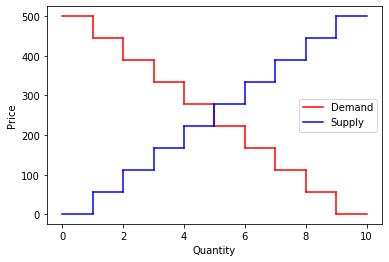

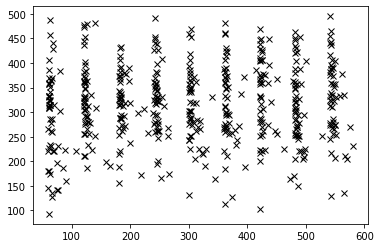

In [25]:
sellers_spec = [('PRSH',5),('ZIC',5)]
buyers_spec = sellers_spec
traders_spec = {'sellers':sellers_spec,'buyers':buyers_spec}

sup_range = (1,500)
dem_range = sup_range

start_time = 0
end_time = 60 * 10
supply_schedule = [{'from': start_time, 'to': end_time, 'ranges': [sup_range], 'stepmode': 'fixed'}]
demand_schedule = [{'from': start_time, 'to': end_time, 'ranges': [dem_range], 'stepmode': 'fixed'}]

sup_dem(10, [sup_range], 10, [dem_range], 'fixed')

order_interval = 60
order_sched = {'sup': supply_schedule, 'dem': demand_schedule,
               'interval': order_interval, 'timemode': 'periodic'}

trial_id = 'test1_PRSH_ZIC'
tdump = open('test1_PRSH_ZIC_avg_balance.csv','w')
dump_all = True
verbose = False
market_session(trial_id, start_time, end_time, traders_spec, order_sched, tdump, dump_all, verbose)
tdump.close()
plot_trades('test1_PRSH_ZIC')
n_runs_plot(10, trial_id, start_time, end_time, traders_spec, order_sched)

In [24]:
# in this cell we will be plotting the table that will be included in my paper
import pandas as pd
import statistics
df = pd.read_csv('test1_PRSH_ZIP_transactions.csv')
y_ZIP=df.iloc[:,2]#values of the transaction, I want the average
df_1 = pd.read_csv('test1_PRSH_ZIC_transactions.csv')
y_ZIC = df_1.iloc[:,2]#values of the transaction, I want the average
df_2 = pd.read_csv('test1_PRSH_PRZI_transactions.csv')
y_PRZI = df_2.iloc[:,2]#values of the transaction, I want the average
fd = pd.read_csv('test1_PRSH_ZIP_transactions.csv')
t_1 = max(fd[fd.columns[2]])
fd_1 = pd.read_csv('test1_PRSH_ZIC_transactions.csv')
t_2 = max(fd_1[fd_1.columns[2]])
fd_3 = pd.read_csv('test1_PRSH_PRZI_transactions.csv')
t_3 = max(fd_3[fd_3.columns[2]])
print(t_1,t_2,t_3)

heterogeneousbalanced_info = {'5 PRSH agents against':['5 PRZI agents','5 ZIC agents','5 ZIP agents'],'Mean Transaction Value':
                    [statistics.mean(y_PRZI),statistics.mean(y_ZIC),statistics.mean(y_ZIP)],'Average Profit per Trading Agent':[],
                              'Total Profit (PRSH,Other Agent)':['2301, 8352',],'Highest Trade Price':[t_1,t_2,t_3]}
print(tabulate(heterogeneousbalanced_info,headers='keys',tablefmt='pretty'))
print()

397 449 489
+-----------------------+------------------------+----------------------------------+---------------------------------+---------------------+
| 5 PRSH agents against | Mean Transaction Value | Average Profit per Trading Agent | Total Profit (PRSH,Other Agent) | Highest Trade Price |
+-----------------------+------------------------+----------------------------------+---------------------------------+---------------------+
|     5 PRZI agents     |   319.97297297297297   |                                  |           2301, 8352            |         397         |
|     5 ZIC agents      |   310.60869565217394   |                                  |                                 |         449         |
|     5 ZIP agents      |   306.9512195121951    |                                  |                                 |         489         |
+-----------------------+------------------------+----------------------------------+---------------------------------+-----------------

In [37]:
#we use the values in the columns of the transaction.csv files for the two bots with the highest total profit. 
import scipy
import scipy.stats
df = pd.read_csv('test1_PRSH_ZIC_transactions.csv')
dff = pd.read_csv('test1_PRSH_PRZI_transactions.csv')
x = df[df.columns[2]]
y = dff[dff.columns[2]]
scipy.stats.mannwhitneyu(x,y)

MannwhitneyuResult(statistic=821.5, pvalue=0.39523180680054937)

In [33]:
df = pd.read_csv('test1_PRSH_PRZI_avg_balance.csv')
x_1_1 = stats.mean(df[df.columns[7]])
x_1_2 = stats.mean(df[df.columns[11]])
df1 = pd.read_csv('test1_PRSH_ZIC_avg_balance.csv')
x_2_1 = stats.mean(df1[df1.columns[7]])
x_2_2 = stats.mean(df1[df1.columns[11]])
df2= pd.read_csv('test1_PRSH_ZIP_avg_balance.csv')
x_3_1 = stats.mean(df2[df2.columns[7]])
x_3_2 = stats.mean(df2[df2.columns[11]])
print(x_1_1,x_1_2)
print(x_2_1,x_2_2)
print(x_3_1,x_3_2)

125.0078947368421 442.2631578947368
305.23191489361704 306.20212765957444
197.20714285714286 344.55238095238093


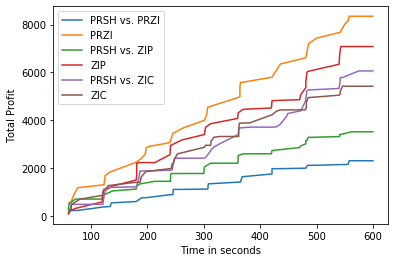

In [33]:
df = pd.read_csv('test1_PRSH_PRZI_avg_balance.csv')
df = df.set_index(df[df.columns[1]])
x = df[df.columns[5]]
y = df[df.columns[9]]
df1 = pd.read_csv('test1_PRSH_ZIP_avg_balance.csv')
df1 = df1.set_index(df1[df1.columns[1]])
x1 = df1[df1.columns[5]]
y1 = df1[df1.columns[9]]
df2 = pd.read_csv('test1_PRSH_ZIC_avg_balance.csv')
df2 = df2.set_index(df2[df2.columns[1]])
x2 = df2[df2.columns[5]]
y2 = df2[df2.columns[9]]
plt.plot(figsize=(5,5))
plt.plot(x,label = 'PRSH vs. PRZI')
plt.plot(y,label = 'PRZI')
plt.plot(x1,label = 'PRSH vs. ZIP')
plt.plot(y1,label='ZIP')
plt.plot(x2,label = 'PRSH vs. ZIC')
plt.plot(y2,label='ZIC')
plt.xlabel('Time in seconds')
plt.ylabel('Total Profit')
plt.legend()

### One in Many

In this type of heterogeneous test, we put one trading-agent in a sea of 9 trading agents of another type and see what happens. Since we are only interested in how PRSH competes, PRSH will feature in each of our experiments.

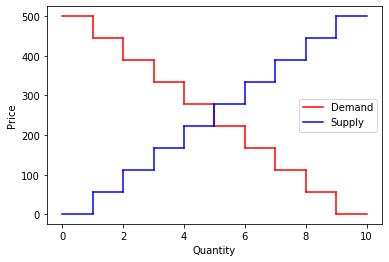

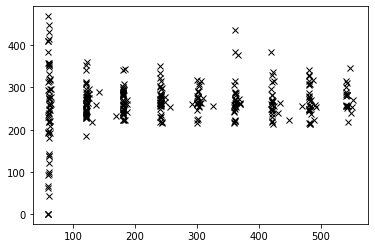

In [2]:
sellers_spec = [('PRSH',1),('ZIP',9)]
buyers_spec = sellers_spec
traders_spec = {'sellers':sellers_spec,'buyers':buyers_spec}

sup_range = (1,500)
dem_range = sup_range

start_time = 0
end_time = 60 * 10
supply_schedule = [{'from': start_time, 'to': end_time, 'ranges': [sup_range], 'stepmode': 'fixed'}]
demand_schedule = [{'from': start_time, 'to': end_time, 'ranges': [dem_range], 'stepmode': 'fixed'}]

sup_dem(10, [sup_range], 10, [dem_range], 'fixed')

order_interval = 60
order_sched = {'sup': supply_schedule, 'dem': demand_schedule,
               'interval': order_interval, 'timemode': 'periodic'}

trial_id = 'test_PRSH1_ZIP9'
tdump = open('test_PRSH1_ZIP9_avg_balance.csv','w')
dump_all = True
verbose = False

market_session(trial_id, start_time, end_time, traders_spec, order_sched, tdump, dump_all, verbose)

tdump.close()

plot_trades('test_PRSH1_ZIP9')

n_runs_plot(10, trial_id, start_time, end_time, traders_spec, order_sched)

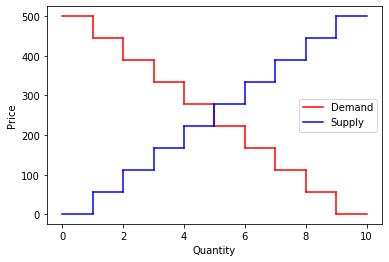

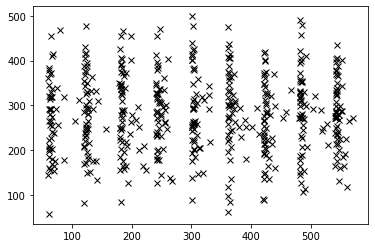

In [3]:
sellers_spec = [('PRSH',1),('ZIC',9)]
buyers_spec = sellers_spec
traders_spec = {'sellers':sellers_spec,'buyers':buyers_spec}

sup_range = (1,500)
dem_range = sup_range

start_time = 0
end_time = 60 * 10
supply_schedule = [{'from': start_time, 'to': end_time, 'ranges': [sup_range], 'stepmode': 'fixed'}]
demand_schedule = [{'from': start_time, 'to': end_time, 'ranges': [dem_range], 'stepmode': 'fixed'}]

sup_dem(10, [sup_range], 10, [dem_range], 'fixed')

order_interval = 60
order_sched = {'sup': supply_schedule, 'dem': demand_schedule,
               'interval': order_interval, 'timemode': 'periodic'}

trial_id = 'test_PRSH1_ZIC9'
tdump = open('test_PRSH1_ZIC9_avg_balance.csv','w')
dump_all = True
verbose = False

market_session(trial_id, start_time, end_time, traders_spec, order_sched, tdump, dump_all, verbose)

tdump.close()

plot_trades('test_PRSH1_ZIC9')

n_runs_plot(10, trial_id, start_time, end_time, traders_spec, order_sched)

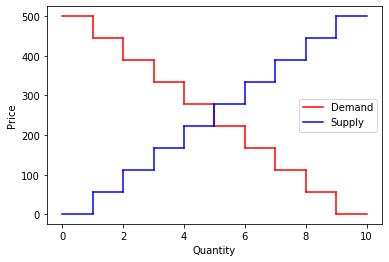

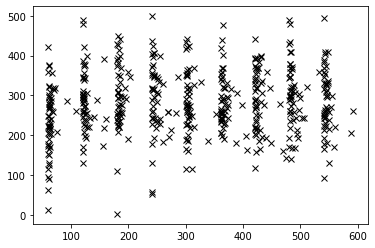

In [4]:
sellers_spec = [('PRSH',1),('PRZI',9)]
buyers_spec = sellers_spec
traders_spec = {'sellers':sellers_spec,'buyers':buyers_spec}

sup_range = (1,500)
dem_range = sup_range

start_time = 0
end_time = 60 * 10
supply_schedule = [{'from': start_time, 'to': end_time, 'ranges': [sup_range], 'stepmode': 'fixed'}]
demand_schedule = [{'from': start_time, 'to': end_time, 'ranges': [dem_range], 'stepmode': 'fixed'}]

sup_dem(10, [sup_range], 10, [dem_range], 'fixed')

order_interval = 60
order_sched = {'sup': supply_schedule, 'dem': demand_schedule,
               'interval': order_interval, 'timemode': 'periodic'}

trial_id = 'test_PRSH1_PRZI9'
tdump = open('test_PRSH1_PRZI9_avg_balance.csv','w')
dump_all = True
verbose = False

market_session(trial_id, start_time, end_time, traders_spec, order_sched, tdump, dump_all, verbose)

tdump.close()

plot_trades('test_PRSH1_PRZI9')

n_runs_plot(10, trial_id, start_time, end_time, traders_spec, order_sched)

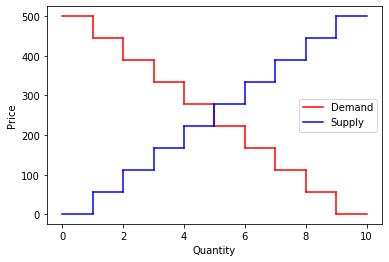

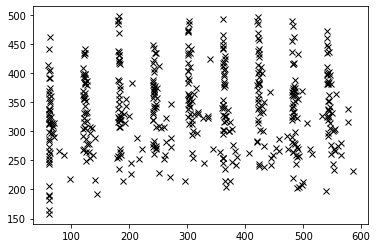

In [5]:
sellers_spec = [('PRSH',9),('ZIP',1)]
buyers_spec = sellers_spec
traders_spec = {'sellers':sellers_spec,'buyers':buyers_spec}

sup_range = (1,500)
dem_range = sup_range

start_time = 0
end_time = 60 * 10
supply_schedule = [{'from': start_time, 'to': end_time, 'ranges': [sup_range], 'stepmode': 'fixed'}]
demand_schedule = [{'from': start_time, 'to': end_time, 'ranges': [dem_range], 'stepmode': 'fixed'}]

sup_dem(10, [sup_range], 10, [dem_range], 'fixed')

order_interval = 60
order_sched = {'sup': supply_schedule, 'dem': demand_schedule,
               'interval': order_interval, 'timemode': 'periodic'}

trial_id = 'test_PRSH9_ZIP1'
tdump = open('test_PRSH9_ZIP1_avg_balance.csv','w')
dump_all = True
verbose = False

market_session(trial_id, start_time, end_time, traders_spec, order_sched, tdump, dump_all, verbose)

tdump.close()

plot_trades('test_PRSH9_ZIP1')

n_runs_plot(10, trial_id, start_time, end_time, traders_spec, order_sched)

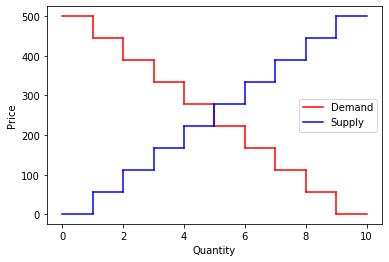

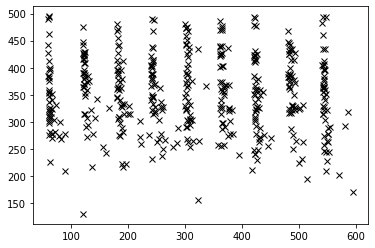

In [6]:
sellers_spec = [('PRSH',9),('ZIC',1)]
buyers_spec = sellers_spec
traders_spec = {'sellers':sellers_spec,'buyers':buyers_spec}

sup_range = (1,500)
dem_range = sup_range

start_time = 0
end_time = 60 * 10
supply_schedule = [{'from': start_time, 'to': end_time, 'ranges': [sup_range], 'stepmode': 'fixed'}]
demand_schedule = [{'from': start_time, 'to': end_time, 'ranges': [dem_range], 'stepmode': 'fixed'}]

sup_dem(10, [sup_range], 10, [dem_range], 'fixed')

order_interval = 60
order_sched = {'sup': supply_schedule, 'dem': demand_schedule,
               'interval': order_interval, 'timemode': 'periodic'}

trial_id = 'test_PRSH9_ZIC1'
tdump = open('test_PRSH9_ZIC1_avg_balance.csv','w')
dump_all = True
verbose = False

market_session(trial_id, start_time, end_time, traders_spec, order_sched, tdump, dump_all, verbose)

tdump.close()

plot_trades('test_PRSH9_ZIC1')

n_runs_plot(10, trial_id, start_time, end_time, traders_spec, order_sched)

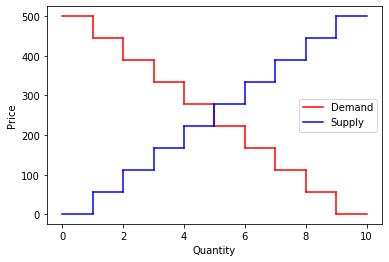

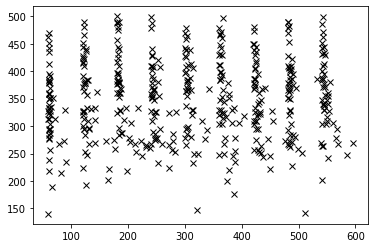

In [7]:
sellers_spec = [('PRSH',9),('PRZI',1)]
buyers_spec = sellers_spec
traders_spec = {'sellers':sellers_spec,'buyers':buyers_spec}

sup_range = (1,500)
dem_range = sup_range

start_time = 0
end_time = 60 * 10
supply_schedule = [{'from': start_time, 'to': end_time, 'ranges': [sup_range], 'stepmode': 'fixed'}]
demand_schedule = [{'from': start_time, 'to': end_time, 'ranges': [dem_range], 'stepmode': 'fixed'}]

sup_dem(10, [sup_range], 10, [dem_range], 'fixed')

order_interval = 60
order_sched = {'sup': supply_schedule, 'dem': demand_schedule,
               'interval': order_interval, 'timemode': 'periodic'}

trial_id = 'test_PRSH9_PRZI1'
tdump = open('test_PRSH9_PRZI1_avg_balance.csv','w')
dump_all = True
verbose = False

market_session(trial_id, start_time, end_time, traders_spec, order_sched, tdump, dump_all, verbose)

tdump.close()

plot_trades('test_PRSH9_PRZI1')

n_runs_plot(10, trial_id, start_time, end_time, traders_spec, order_sched)

In [13]:
df = pd.read_csv('test_PRSH9_PRZI1_transactions.csv')
print(stats.mean(df[df.columns[2]]))
print(max(df[df.columns[2]]))
df = pd.read_csv('test_PRSH9_ZIC1_transactions.csv')
print(stats.mean(df[df.columns[2]]))
print(max(df[df.columns[2]]))
df = pd.read_csv('test_PRSH9_ZIP1_transactions.csv')
print(stats.mean(df[df.columns[2]]))
print(max(df[df.columns[2]]))


337.4761904761905
489
342.07894736842104
494
321.04545454545456
432


In [26]:
df = pd.read_csv('test_PRSH1_PRZI9_transactions.csv')
print(stats.mean(df[df.columns[2]]))
print(max(df[df.columns[2]]))
df = pd.read_csv('test_PRSH1_ZIP9_transactions.csv')
print(stats.mean(df[df.columns[2]]))
print(max(df[df.columns[2]]))
df = pd.read_csv('test_PRSH1_ZIC9_transactions.csv')
print(stats.mean(df[df.columns[2]]))
print(max(df[df.columns[2]]))

268.3695652173913
439
263.22222222222223
352
295.3695652173913
477


In [23]:
df = pd.read_csv('test_PRSH9_PRZI1_avg_balance.csv')
print(stats.mean(df[df.columns[7]]))
print(stats.mean(df[df.columns[11]]))
df = pd.read_csv('test_PRSH9_ZIC1_avg_balance.csv')
print(stats.mean(df[df.columns[7]]))
print(stats.mean(df[df.columns[11]]))
df = pd.read_csv('test_PRSH9_ZIP1_avg_balance.csv')
print(stats.mean(df[df.columns[7]]))
print(stats.mean(df[df.columns[11]]))

350.93669246511627
39.627906976744185
359.03846153846155
0.0
289.91728395555555
460.0777777777778


In [27]:
df = pd.read_csv('test_PRSH1_PRZI9_avg_balance.csv')
print(stats.mean(df[df.columns[7]]))
print(stats.mean(df[df.columns[11]]))
df = pd.read_csv('test_PRSH1_ZIP9_avg_balance.csv')
print(stats.mean(df[df.columns[7]]))
print(stats.mean(df[df.columns[11]]))
df = pd.read_csv('test_PRSH1_ZIC9_avg_balance.csv')
print(stats.mean(df[df.columns[7]]))
print(stats.mean(df[df.columns[11]]))

257.6170212765957
323.54018910638297
548.0
171.42261910714288
98.2872340425532
334.3392434680851


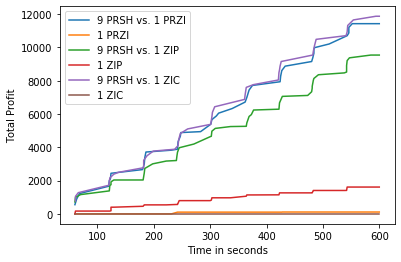

In [32]:
df = pd.read_csv('test_PRSH9_PRZI1_avg_balance.csv')
df = df.set_index(df[df.columns[1]])
x = df[df.columns[5]]
y = df[df.columns[9]]
df1 = pd.read_csv('test_PRSH9_ZIP1_avg_balance.csv')
df1 = df1.set_index(df1[df1.columns[1]])
x1 = df1[df1.columns[5]]
y1 = df1[df1.columns[9]]
df2 = pd.read_csv('test_PRSH9_ZIC1_avg_balance.csv')
df2 = df2.set_index(df2[df2.columns[1]])
x2 = df2[df2.columns[5]]
y2 = df2[df2.columns[9]]
plt.plot(figsize=(5,5))
plt.plot(x,label = '9 PRSH vs. 1 PRZI')
plt.plot(y,label = '1 PRZI')
plt.plot(x1,label = '9 PRSH vs. 1 ZIP')
plt.plot(y1,label='1 ZIP')
plt.plot(x2,label = '9 PRSH vs. 1 ZIC')
plt.plot(y2,label='1 ZIC')
plt.xlabel('Time in seconds')
plt.ylabel('Total Profit')
plt.legend()

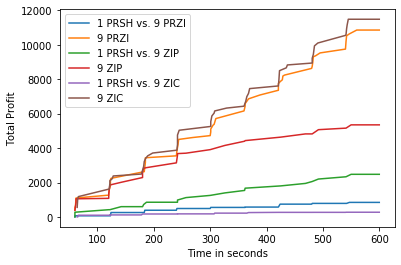

In [31]:
# Time series plot for one-in-many experiment 1 vs 9
df = pd.read_csv('test_PRSH1_PRZI9_avg_balance.csv')
df = df.set_index(df[df.columns[1]])
x = df[df.columns[5]]
y = df[df.columns[9]]
df1 = pd.read_csv('test_PRSH1_ZIP9_avg_balance.csv')
df1 = df1.set_index(df1[df1.columns[1]])
x1 = df1[df1.columns[5]]
y1 = df1[df1.columns[9]]
df2 = pd.read_csv('test_PRSH1_ZIC9_avg_balance.csv')
df2 = df2.set_index(df2[df2.columns[1]])
x2 = df2[df2.columns[5]]
y2 = df2[df2.columns[9]]
plt.plot(figsize=(5,5))
plt.plot(x,label = '1 PRSH vs. 9 PRZI')
plt.plot(y,label = '9 PRZI')
plt.plot(x1,label = '1 PRSH vs. 9 ZIP')
plt.plot(y1,label='9 ZIP')
plt.plot(x2,label = '1 PRSH vs. 9 ZIC')
plt.plot(y2,label='9 ZIC')
plt.xlabel('Time in seconds')
plt.ylabel('Total Profit')
plt.legend()

## PRSH Improvement

In [ ]:
sellers_spec = [('PRSH2',10)]
buyers_spec = sellers_spec
traders_spec = {'sellers':sellers_spec,'buyers':buyers_spec}

sup_range = (1,500)
dem_range = sup_range

start_time = 0
end_time = 60 * 10
supply_schedule = [{'from': start_time, 'to': end_time, 'ranges': [sup_range], 'stepmode': 'fixed'}]
demand_schedule = [{'from': start_time, 'to': end_time, 'ranges': [dem_range], 'stepmode': 'fixed'}]

sup_dem(10, [sup_range], 10, [dem_range], 'fixed')

order_interval = 60
order_sched = {'sup': supply_schedule, 'dem': demand_schedule,
               'interval': order_interval, 'timemode': 'periodic'}

trial_id = 'test_PRSH2'
tdump = open('test_PRSH2_avg_balance.csv','w')
dump_all = True
verbose = False

market_session(trial_id, start_time, end_time, traders_spec, order_sched, tdump, dump_all, verbose)

tdump.close()

plot_trades('test_PRSH2')

n_runs_plot(10, trial_id, start_time, end_time, traders_spec, order_sched)